Some basic statistics and visualisations of the data

First some technical initialisations:

In [1]:
!conda update -y dask

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - dask


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.10.16 |                0         131 KB
    dask-core-2.6.0            |             py_0         578 KB
    openssl-1.0.2t             |       h7b6447c_1         3.1 MB
    dask-2.6.0                 |             py_0          12 KB
    certifi-2019.9.11          |           py36_0         154 KB
    partd-1.0.0                |             py_0          19 KB
    distributed-2.6.0          |             py_0         393 KB
    ------------------------------------------------------------
    

In [1]:
import pandas as pd
import psycopg2
from dask.distributed import Client
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
client = Client('Dask-Scheduler.local-dask:8786')

In [3]:
client.get_versions(check=False)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 1 Cores: 2 Memory: 1.80 GB


Loading data:

In [4]:
db_host = '***REMOVED***'
db_port = 5432
db_name = "postgres"
db_user = "***REMOVED***"
db_pass = "***REMOVED***"
loiste_bbox = '25,62.7,31.4,66.4'
sssoy_bbox  = '24.5,60,30.6,63.5'

In [5]:
def get_polygons_over_network(start, end, bbox):
    """ Get polygons from db """

    conn = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s'" % (db_name, db_user, db_host, db_pass))
    
    sql = """
        SELECT weather_parameter,low_limit,high_limit,point_in_time 
        FROM sasse.stormcell 
        WHERE ST_MakeEnvelope({bbox}, 4326) && geom 
         AND point_in_time >= '{start}' AND point_in_time < '{end}'
         """.format(bbox=bbox,start=start,end=end)        

    cursor = conn.cursor()
    cursor.execute(sql)
    results = cursor.fetchall()

    print('Found {} records.'.format(len(results)))

    return results

In [6]:
polygons_loiste = get_polygons_over_network('2010-01-01', '2019-01-01',loiste_bbox)
polygons_sssoy = get_polygons_over_network('2010-01-01', '2019-01-01',sssoy_bbox)

Found 44857 records.
Found 61116 records.


In [7]:
df = pd.DataFrame(polygons_loiste, columns=['Parameter','Low Limit','High Limit','Time'])
df.sort_values(by=['Time', 'Parameter','Low Limit'], inplace=True)
df.set_index('Time', inplace=True)
#df = dd.DataFrame(polygons_loiste) #, columns=['Parameter','Low Limit','High Limit','Time'])

# Amount of polygons

Number of polygons over Loiste network

In [11]:
df.groupby(['Parameter', 'Low Limit']).count()

High Limit
Parameter Low Limit            
Pressure  0               25261
WindGust  15              18345
          20               1202
          25                 49

We can see that number of 15 m/s wind gust polygons are distributed quite evenly over time. However, Windgusts over 20 m/s are extremely rare and over 25 m/s gusts we have had only few times during this history. 

Number of pressure polygons is suspiciously high (24 is on storm with 24 time steps). Maybe we should use lower threshold? 

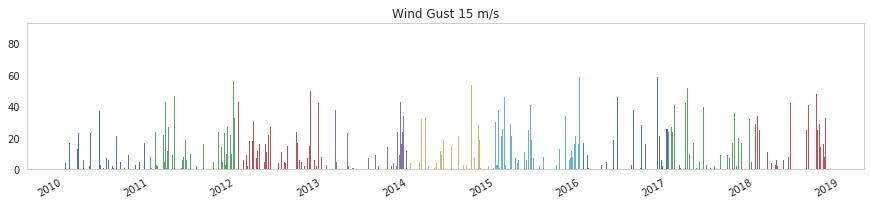

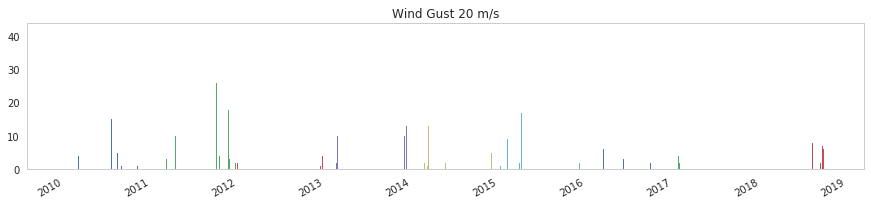

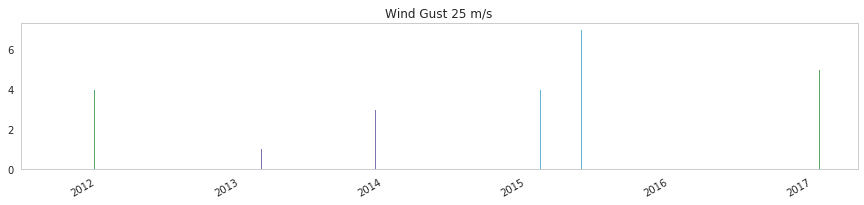

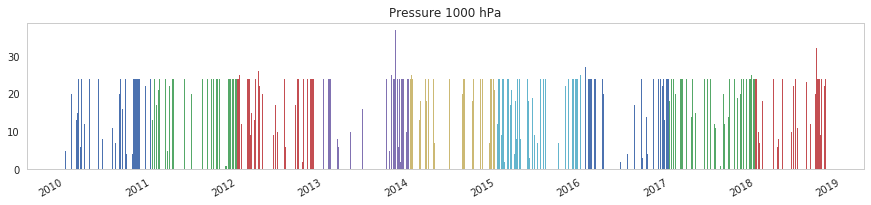

In [84]:
def plot_count(df, title):
    years = range(2010,2019)
    fig, ax = plt.subplots(figsize=(15,3))
    i = 0
    for y in years:
        dfy = df.loc['{}0101'.format(y):'{}1231'.format(y), :]    
        s = dfy.loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count()
        plt.bar(s.index.to_pydatetime(),s.values)
    i += 1

    #plt.locator_params(nbins=10)
    plt.grid(False)
    #plt.legend()
    plt.title(title)
    plt.gcf().autofmt_xdate()
    
plot_count(df[(df.loc[:,'Parameter'] == 'WindGust') & (df.loc[:,'Low Limit'] == 15)], 'Wind Gust 15 m/s')
plot_count(df[(df.loc[:,'Parameter'] == 'WindGust') & (df.loc[:,'Low Limit'] == 20)], 'Wind Gust 20 m/s')
plot_count(df[(df.loc[:,'Parameter'] == 'WindGust') & (df.loc[:,'Low Limit'] == 25)], 'Wind Gust 25 m/s')
plot_count(df[(df.loc[:,'Parameter'] == 'Pressure')], 'Pressure 1000 hPa')

KilledWorker: ("('from_pandas-bc50a01c1abc17561adfa7060bcad1cd', 5)", <Worker 'tcp://172.31.28.227:9000', memory: 0, processing: 8>)

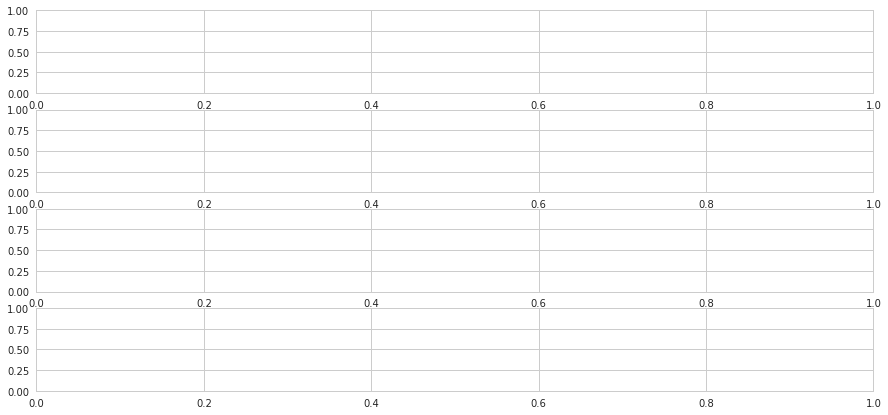

In [12]:
dfd = dd.from_pandas(df, npartitions=8) 
client.persist(dfd)
fig, axes = plt.subplots(figsize=(15,7), nrows=4, ncols=1)
dfd[(dfd.loc[:,'Parameter'] == 'Pressure')].loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count().compute().plot(kind='bar', ax=axes[0], label='Pressure')
#dfd[(dfd.loc[:,'Parameter'] == 'WindGust') & (dfd.loc[:,'Low Limit'] == 15)].loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count().plot(kind='bar', ax=axes[1], label='Wind Gust 15 m/s', color='y')
#dfd[(dfd.loc[:,'Parameter'] == 'WindGust') & (dfd.loc[:,'Low Limit'] == 20)].loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count().plot(kind='bar', ax=axes[2], label='Wind Gust 20 m/s', color='g')
#dfd[(dfd.loc[:,'Parameter'] == 'WindGust') & (dfd.loc[:,'Low Limit'] == 25)].loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count().plot(kind='bar', ax=axes[3], label='Wind Gust 20 m/s', color='r')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%h'));
plt.legend()

In [19]:
df.head()

,Parameter,Low Limit,High Limit
Time,,,
2010-01-03 14:00:00+00:00,Pressure,0,1000
2010-01-03 15:00:00+00:00,Pressure,0,1000
2010-01-03 16:00:00+00:00,Pressure,0,1000
2010-01-03 17:00:00+00:00,Pressure,0,1000
2010-01-03 18:00:00+00:00,Pressure,0,1000
2010-01-03 19:00:00+00:00,Pressure,0,1000
2010-01-03 20:00:00+00:00,Pressure,0,1000
2010-01-03 21:00:00+00:00,Pressure,0,1000
2010-01-03 22:00:00+00:00,Pressure,0,1000
